<div style="background:#ddffff;border-left: 6px solid #2196f3;">
<h1 style="text-align:center;">Denoising noisy signals</h1>
<hr style="width:65%;height:2px;border-width:1;color:gray;background-color:gray;">
<p style="padding-left:20px;padding-right:20px;">We are going to generate pure signals, add noise, try to remove it, and compare it with the original</p>
<p style="padding-left:20px;padding-right:20px;">First is the running-mean filter.</p>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend

In [2]:
def runningMeanFilter(x, k):
    length = len(x)
    y = np.zeros(length)
    for i in range(length):
        start = max(i - k, 0)
        end = min(i + k, length) + 1
        y[i] = np.mean(x[start:end])
    return y

def getSignal(time):
    signal = np.zeros(len(time))
    for i in range(1, 4):
        signal += np.cos(i*time)**i
    return signal

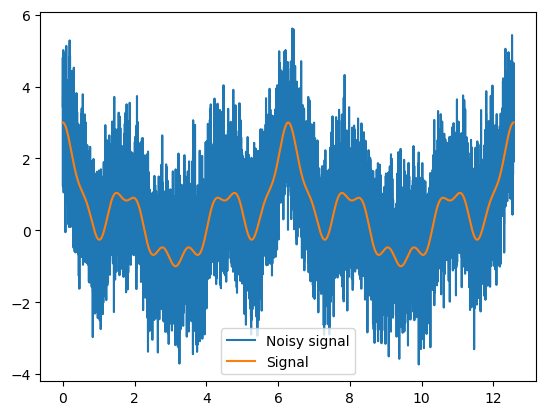

In [3]:
N = 10_001

time = np.linspace(0, 4*np.pi, N)
signal = getSignal(time)
noisySignal = signal + np.random.randn(N)

plt.plot(time, noisySignal, time, signal)
plt.legend(['Noisy signal', 'Signal'])
plt.show()

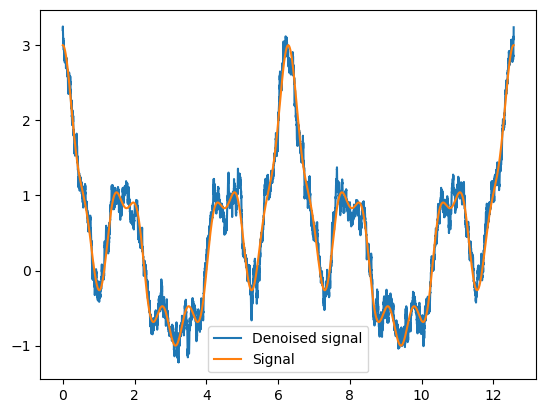

In [4]:
denoisedSignal = runningMeanFilter(noisySignal, 20)
plt.plot(time, denoisedSignal, time, signal)
plt.legend(['Denoised signal', 'Signal'])
plt.show()

In [5]:
kValues = np.arange(0, 51)
correlations = []
for k in kValues:
    denoisedSignal = runningMeanFilter(noisySignal, k)
    correlations.append(np.corrcoef(denoisedSignal, signal)[0,1])

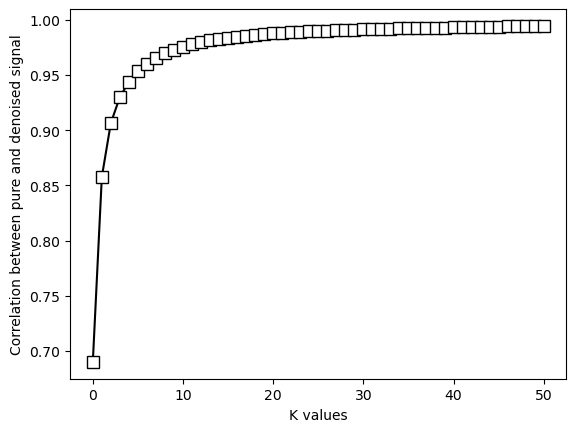

In [6]:
plt.plot(kValues, correlations, 'ks-', markerfacecolor='w', markersize=8)
plt.xlabel('K values')
plt.ylabel('Correlation between pure and denoised signal')
plt.show()

<div style="background:#ddffff;border-left: 6px solid #2196f3;">
<h1 style="text-align:center;">Gaussian convolution</h1>
<hr style="width:65%;height:2px;border-width:1;color:gray;background-color:gray;">
<p style="padding-left:20px;padding-right:20px;">We are going to 'slide' a gaussian through the noisy signal, and at each point we will compute the dot-product.</p>
</div>

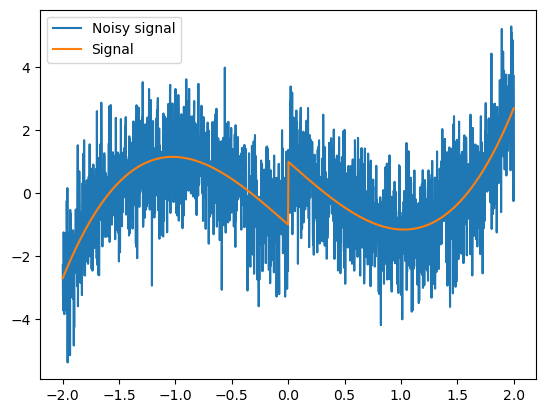

In [7]:
samplingRate = 512
time = np.arange(-2, 2 + 1/samplingRate, 1/samplingRate)
length = len(time)

signal = time**3 + np.sign(time)
signal = detrend(signal)
noisySignal = signal + np.random.randn(length) * 1.1

plt.plot(time, noisySignal, time, signal)
plt.legend(['Noisy signal', 'Signal'])
plt.show()

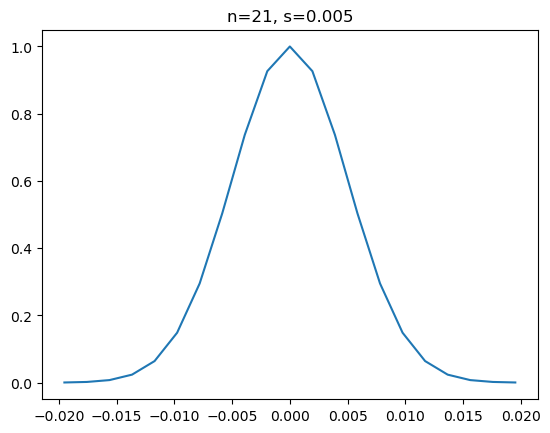

In [8]:
k = 10
x = np.arange(-k, k+1)/samplingRate
s = .005

gkern = np.exp((-x**2) / (2*s**2))

plt.plot(x, gkern)
plt.title('n=%s, s=%g'%(2*k+1,s))
plt.show()

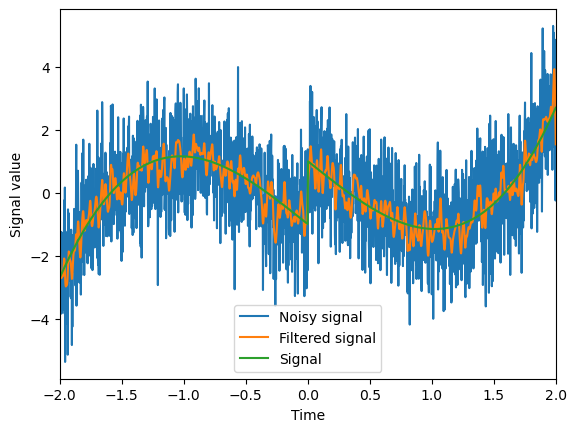

In [9]:
gkern = gkern / sum(gkern) # Normalization. Sum of it will be one.
filteredSignal = np.convolve(noisySignal, gkern, mode='same')

plt.plot(time, noisySignal, time, filteredSignal, time, signal)
plt.legend(['Noisy signal', 'Filtered signal', 'Signal'])
plt.xlabel('Time')
plt.ylabel('Signal value')
plt.xlim(time[0], time[-1])
plt.show()

In [10]:
kValues = np.arange(3, 304, 20) # 3, 23, 43, 63, ...
sValues = np.linspace(.001, .5, 60)
sseMatrix = np.zeros( (len(kValues), len(sValues)) ) # squared sum error

for ki in range(len(kValues)):
    for si in range(len(sValues)):
        k = kValues[ki]
        s = sValues[si]
        x = np.arange(-k, k+1)/samplingRate
        gkern = np.exp((-x**2) / (2*s**2))
        gkern = gkern / np.sum(gkern)
        filteredSignal = np.convolve(noisySignal, gkern, mode='same')
        sseMatrix[ki,si] = np.sum((filteredSignal - signal)**2) # SSE

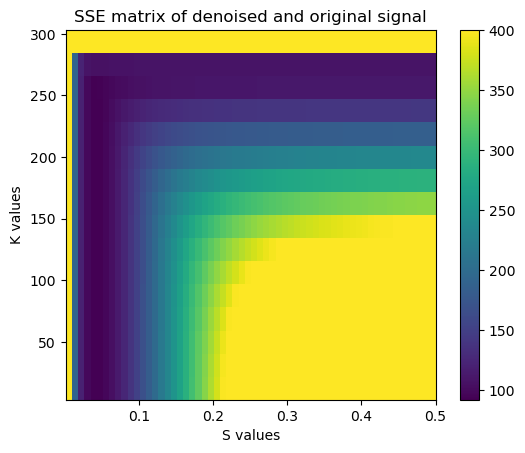

In [11]:
plt.imshow(sseMatrix, vmax=400, extent=[sValues[0], sValues[-1], kValues[0], kValues[-1]])
plt.gca().set_aspect(1 / plt.gca().get_data_ratio())
plt.xlabel('S values')
plt.ylabel('K values')
plt.title('SSE matrix of denoised and original signal')
plt.colorbar()
plt.show()

<div style="background:#ddffff;border-left: 6px solid #2196f3;">
<h1 style="text-align:center;">Despecking by median filter</h1>
<hr style="width:65%;height:2px;border-width:1;color:gray;background-color:gray;">
</div>

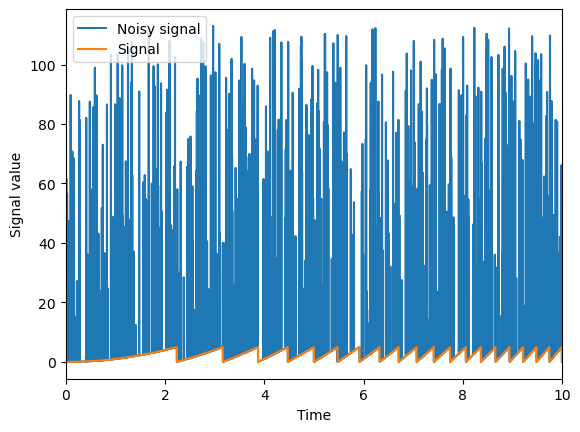

In [58]:
N = 5_001
time = np.linspace(0, 10, N)
signal = time**2 % 5
noisySignal = signal + ((np.random.uniform(0, 1, N) < 0.1) * np.random.uniform(10, 110, N))

plt.plot(time, noisySignal, time, signal)
plt.legend(['Noisy signal', 'Signal'])
plt.xlabel('Time')
plt.ylabel('Signal value')
plt.xlim(time[0], time[-1])
plt.show()

In [59]:
# we specify a threshold and exceeding values will be replaced by the median of the surrounding k values
def medianFilter(noisySignal, threshold, k):
    length = len(noisySignal)
    y = np.zeros(length)
    for i  in range(length):
        if noisySignal[i] < threshold:
            y[i] = noisySignal[i]
            continue
        start = np.max((0, i - k))
        end = np.min((i, length)) + 1
        y[i] = np.median(noisySignal[start:end])
    return y


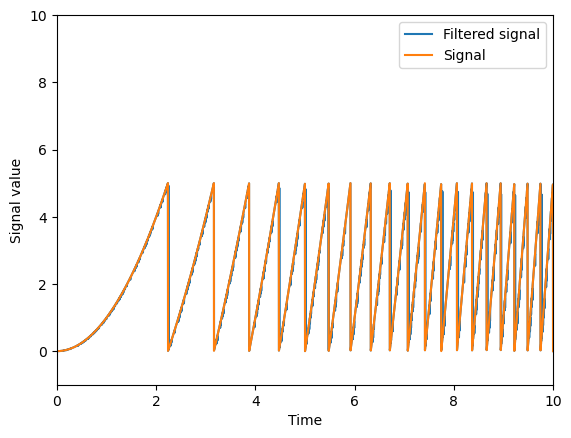

In [61]:
threshold = 8 # If we don't know the threshold, we can make a histogram to have a guess.
k = 20
filteredSignal = medianFilter(noisySignal, threshold, k)

plt.plot(time, filteredSignal, time, signal)
plt.legend(['Filtered signal', 'Signal'])
plt.xlabel('Time')
plt.ylabel('Signal value')
plt.xlim(time[0], time[-1])
plt.ylim(-1, 10)
plt.show()